# Example 1: Preprocessing Workflow

This is meant as a very simple example for a preprocessing workflow. In this workflow we will conduct the following steps:

1. Motion Correction of functional images with FSL's MCFLIRT
2. Image Resampling of anatomical image to a resolution of 3mmx3mmx3mm voxel size with AFNI's 3dresample
3. Image Correction of motion corrected functional images to the resampled anatomical image with FSL's FLIRT
4. Smoothing of coregistrated functional images with FWHM set to 4mm and 8mm

For this example, we have 3 subjects with 2 different runs each. As a short recap, the image properties are:

In [10]:
!nib-ls /data/ds000114/sub-01/*/*.nii.gz

/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz                      float32 [256, 156, 256]      1.00x1.30x1.00         sform
/data/ds000114/sub-01/dwi/sub-01_dwi.nii.gz                        int16  [128, 128,  72,  71] 2.00x2.00x2.00x16.50
/data/ds000114/sub-01/func/sub-01_task-fingerfootlips_bold.nii.gz  int16  [ 64,  64,  30, 184] 4.00x4.00x4.00x2.50    sform
/data/ds000114/sub-01/func/sub-01_task-linebisection_bold.nii.gz   int16  [ 64,  64,  30, 238] 4.00x4.00x4.00x2.50    sform



**So, let's start!**

# Imports

First, let's import all modules we later will be needing.

In [11]:
%pylab inline
from os.path import join as opj
import os
from nipype.interfaces.fsl import MCFLIRT, FLIRT, ExtractROI, BET, FAST, ImageMaths
from nipype.interfaces.afni import Resample
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['extract']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [12]:
experiment_dir = '/data/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-01', 'sub-02']

# list of session identifiers
task_list = ['fingerfootlips', 'linebisection']

# Smoothing widths to apply
fwhm = [4, 8]

# Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [13]:
# ExtractROI - skip dummy scans

extract = Node(ExtractROI(t_min=4, t_size=-1),
               output_type='NIFTI',
               name="extract")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# Resample - resample anatomy to 3x3x3 voxel resolution
resample = Node(Resample(voxel_size=(2, 2, 2),
                         outputtype='NIFTI'),
                name="resample")

# BET - strip the anatomical image
stripper = Node(BET(), name='stripper')

# FAST - get WM segmentation
fast = Node(FAST(), name='fast')

# ImageMaths - binarize the segmentation
binarize = Node(ImageMaths(op_string='-nan -thr 0.5 -bin'),
                name='binarize')

pickindex = lambda x, i: x[i]

# FLIRT - coregister functional images to anatomical images
mean2anat = Node(FLIRT(), name='mean2anat')
mean2anat.inputs.dof = 6

# FLIRT - Now use bbr cost function to improve the transform
mean2anatbbr = Node(FLIRT(), name='mean2anatbbr')
mean2anatbbr.inputs.dof = 6
mean2anatbbr.inputs.cost = 'bbr'
mean2anatbbr.inputs.schedule = opj(os.getenv('FSLDIR'),
                                            'etc/flirtsch/bbr.sch')
# FLIRT - apply the transform
coreg_step2 = Node(FLIRT(output_type='NIFTI',
                         apply_xfm=True), name="coreg_step2")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [14]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('{subject_id}', 'anat', '{subject_id}_T1w.nii.gz')
func_file = opj('{subject_id}', 'func',
                '{subject_id}_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory='/data/ds000114'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
# Use the following DataSink output substitutions
substitutions = [('_subject_id_', ''),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_mcf.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
datasink.inputs.substitutions = substitutions

# Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [15]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, mcflirt, [('roi_file', 'in_file')]),
                 (selectfiles, resample, [('anat', 'in_file')]),

                 (resample, stripper, [('out_file', 'in_file')]),
                 (stripper, fast, [('out_file', 'in_files')]),
                 (fast, binarize, [(('partial_volume_files', pickindex, 2), 'in_file')]),
                 
                 (mcflirt, mean2anat, [('mean_img', 'in_file')]),
                 (stripper, mean2anat, [('out_file', 'reference')]),

                 (mcflirt, mean2anatbbr, [('mean_img', 'in_file')]),
                 (binarize, mean2anatbbr, [('out_file', 'wm_seg')]),
                 (resample, mean2anatbbr, [('out_file', 'reference')]),
                 (mean2anat, mean2anatbbr, [('out_matrix_file', 'in_matrix_file')]),
                 
                 (mcflirt, coreg_step2, [('out_file', 'in_file')]),
                 (resample, coreg_step2, [('out_file', 'reference')]),
                 (mean2anatbbr, coreg_step2, [('out_matrix_file',
                                              'in_matrix_file')]),

                 (coreg_step2, smooth, [('out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (resample, datasink, [('out_file', 'preproc.@resample')]),
                 (mean2anat, datasink, [('out_file', 'preproc.@coregmean')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 ])

# Visualize the workflow

It always helps to visualize your workflow.

170725-16:09:30,113 workflow INFO:
	 Generated workflow graph: /data/output/workingdir/preproc/graph.dot.png (graph2use=colored, simple_form=True).


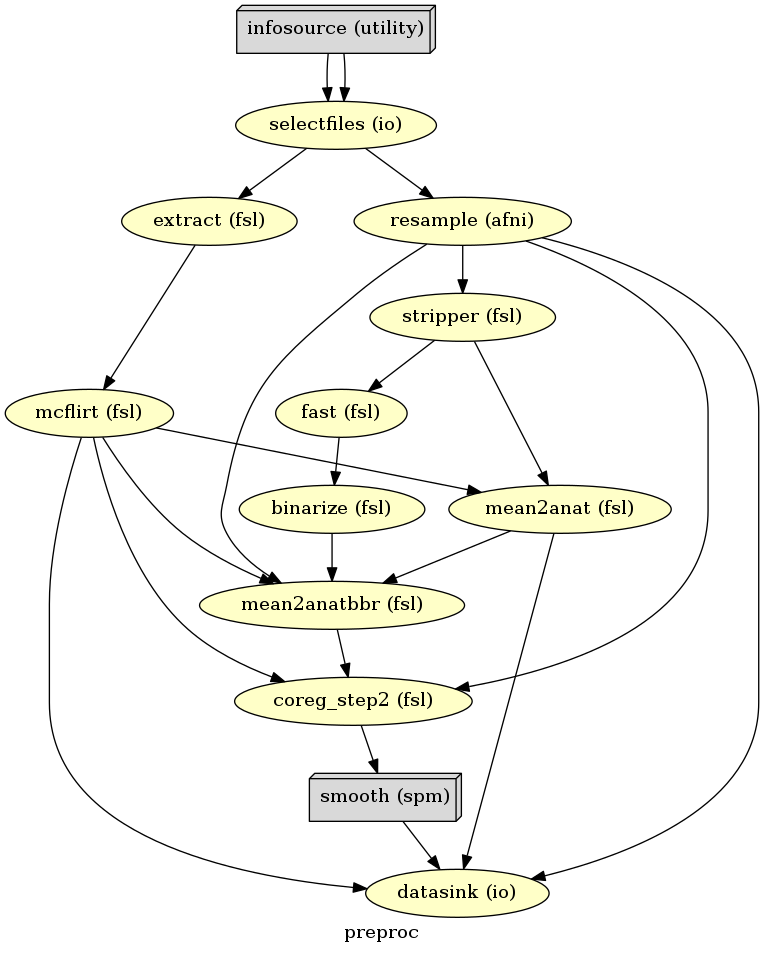

In [16]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.dot.png'))

170725-16:09:30,811 workflow INFO:
	 Generated workflow graph: /data/output/workingdir/preproc/graph.dot.png (graph2use=flat, simple_form=True).


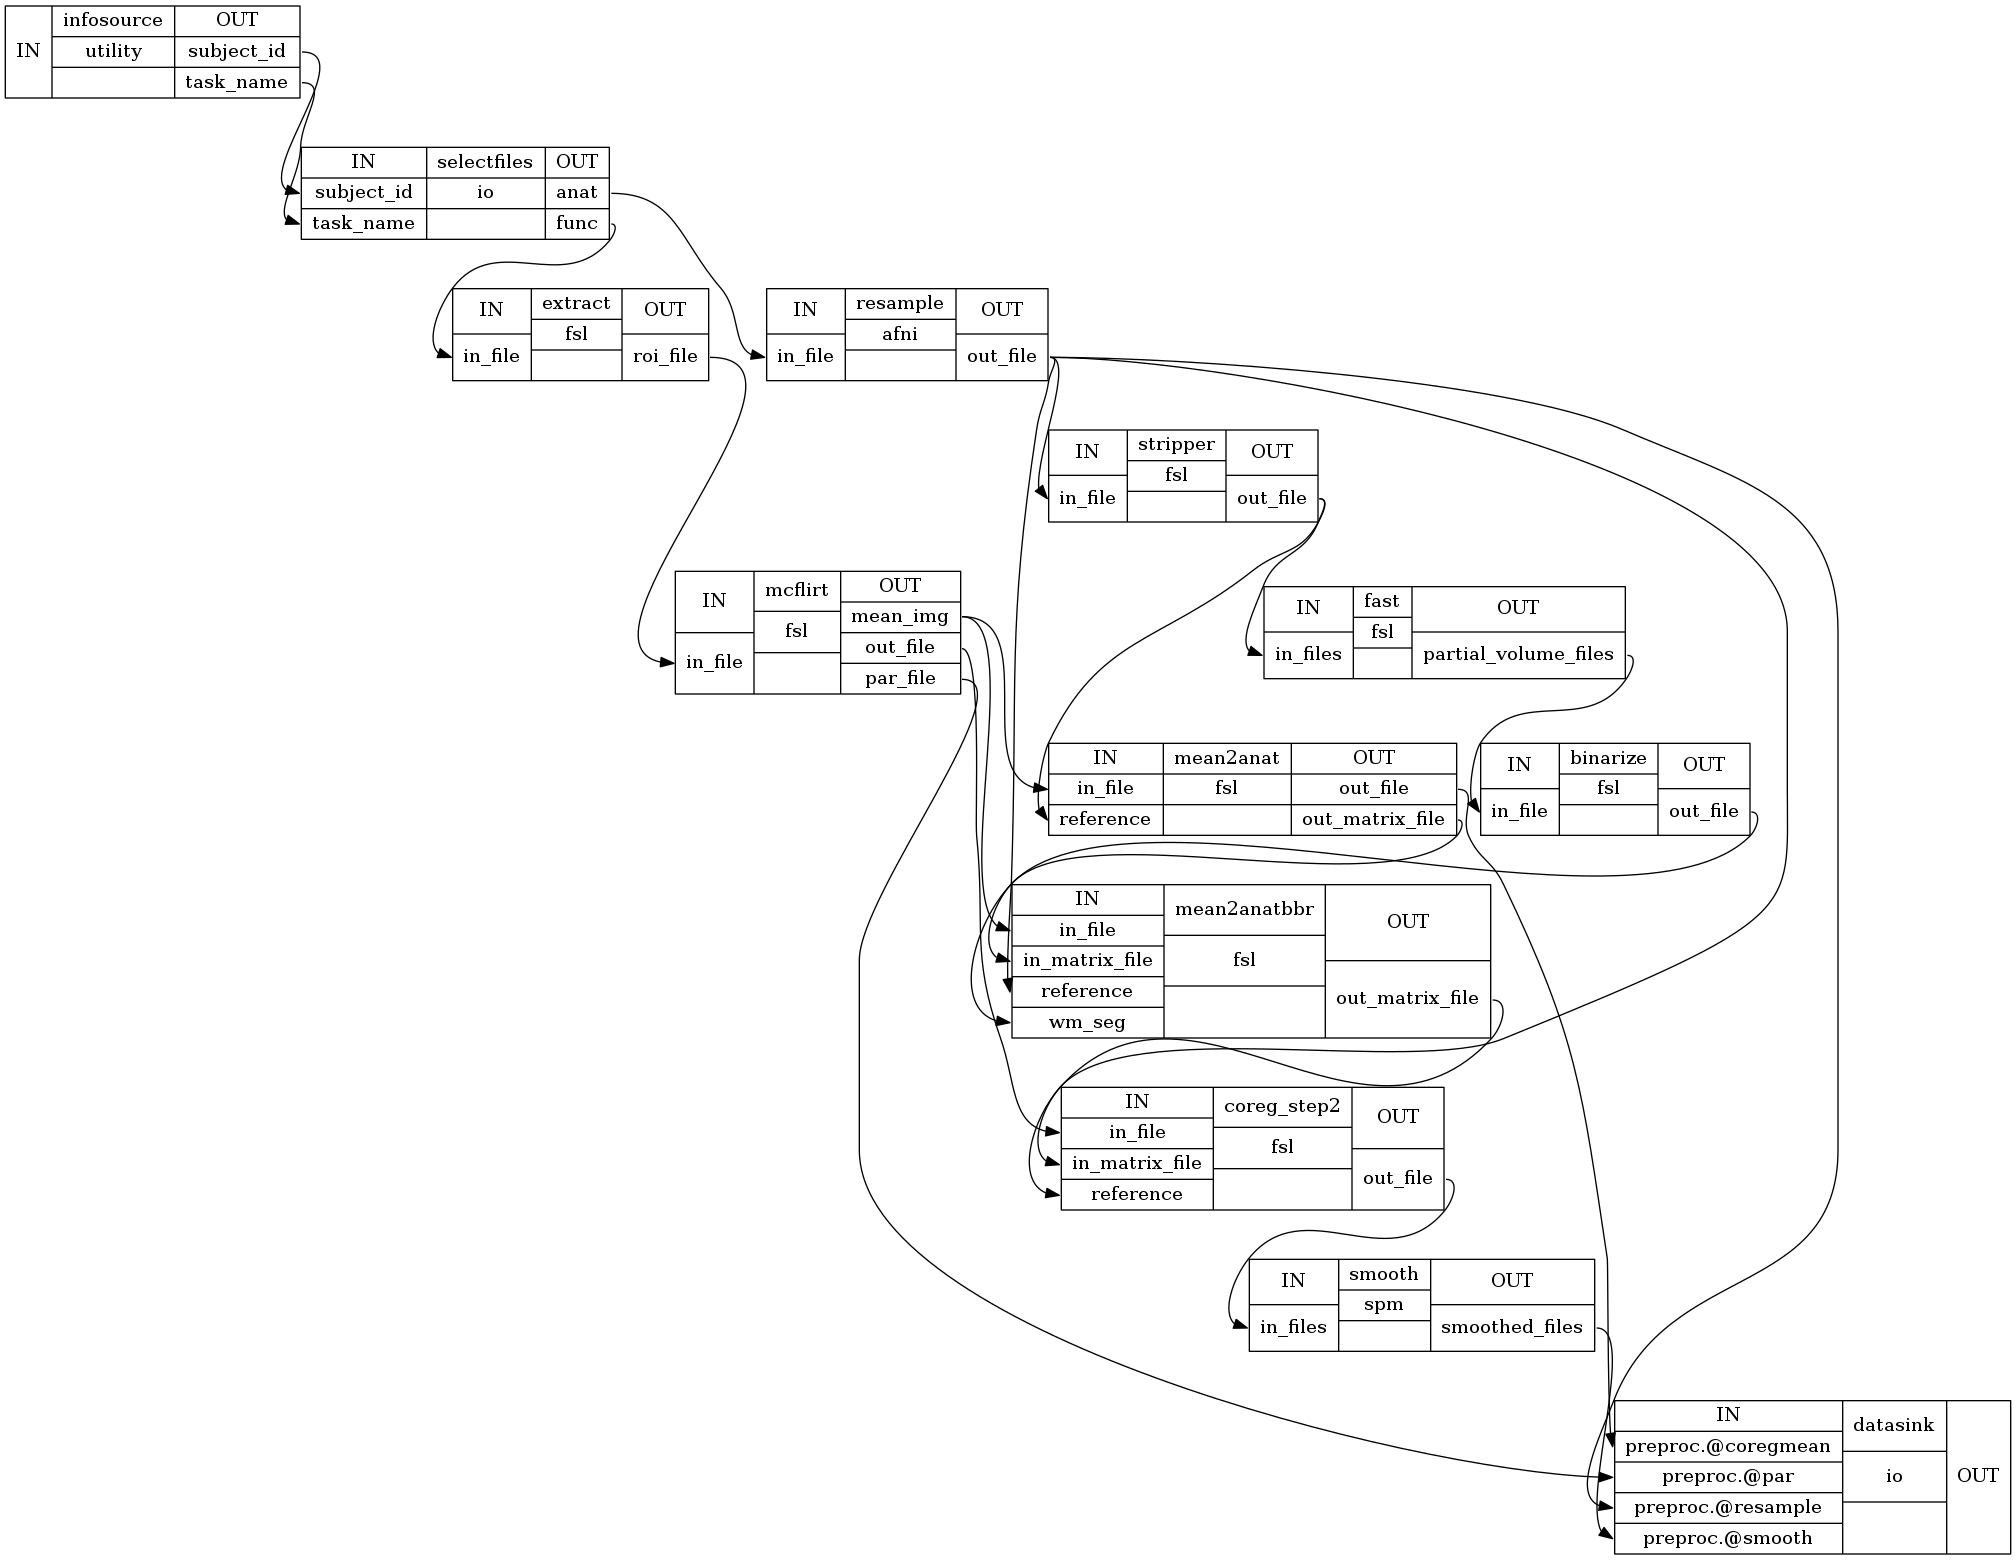

In [17]:
# Visualize the detailed graph
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.dot.png'))

#  Run the Workflow

Now that everything is ready, we can run the preprocessing workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [18]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

170725-16:09:31,457 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
170725-16:09:31,652 workflow INFO:
	 Running in parallel.
170725-16:09:31,662 workflow INFO:
	 Executing: selectfiles.b0 ID: 0
170725-16:09:31,679 workflow INFO:
	 Executing: selectfiles.b1 ID: 2
170725-16:09:31,682 workflow INFO:
	 Executing node selectfiles.b0 in dir: /data/output/workingdir/preproc/_subject_id_sub-01_task_name_fingerfootlips/selectfiles
170725-16:09:31,706 workflow INFO:
	 Executing: selectfiles.b3 ID: 4
170725-16:09:31,710 workflow INFO:
	 Executing node selectfiles.b1 in dir: /data/output/workingdir/preproc/_subject_id_sub-01_task_name_linebisection/selectfiles
170725-16:09:31,724 workflow INFO:
	 Executing: selectfiles.b2 ID: 11
170725-16:09:31,728 workflow INFO:
	 Executing node selectfiles.b3 in dir: /data/output/workingdir/preproc/_subject_id_sub-02_task_name_linebisection/selectfiles
170725-16:09:31,753 workflow INFO:
	 Executing node selectfiles.b2 in dir: /data

RuntimeError: Workflow did not execute cleanly. Check log for details

# Inspect output

let's check the structure of the output folder, to see if we have everything we wanted to save.

In [14]:
!find /data/output/datasink

/data/output/datasink
/data/output/datasink/preproc
/data/output/datasink/preproc/sub-01
/data/output/datasink/preproc/sub-01/task-fingerfootlips
/data/output/datasink/preproc/sub-01/task-fingerfootlips/fwhm-4
/data/output/datasink/preproc/sub-01/task-fingerfootlips/fwhm-4/ssub-01_task-fingerfootlips_bold_roi_mcf_flirt.nii
/data/output/datasink/preproc/sub-01/task-fingerfootlips/fwhm-8
/data/output/datasink/preproc/sub-01/task-fingerfootlips/fwhm-8/ssub-01_task-fingerfootlips_bold_roi_mcf_flirt.nii
/data/output/datasink/preproc/sub-01/task-fingerfootlips/sub-01_T1w_resample.nii
/data/output/datasink/preproc/sub-01/task-fingerfootlips/sub-01_task-fingerfootlips_bold_roi_mcf.par
/data/output/datasink/preproc/sub-01/task-fingerfootlips/sub-01_task-fingerfootlips_bold_roi_mean_flirt.nii.gz
/data/output/datasink/preproc/sub-01/task-linebisection
/data/output/datasink/preproc/sub-01/task-linebisection/fwhm-4
/data/output/datasink/preproc/sub-01/task-linebisection/fwhm-4/ssub-01_task-linebise

# Visualize results

let's check the effect of the different smoothing kernels.

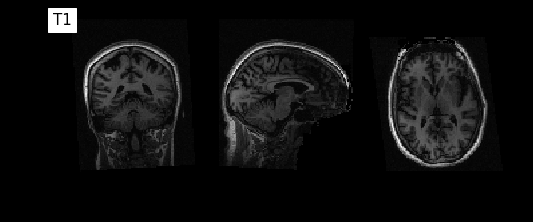

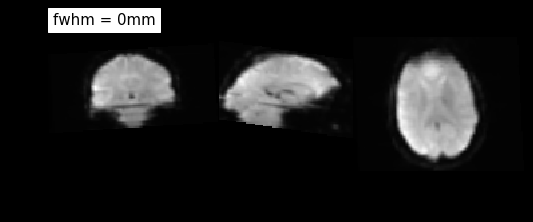

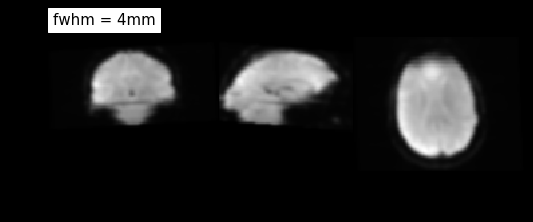

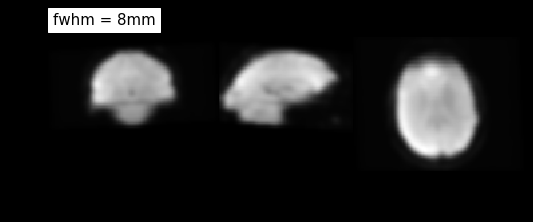

In [17]:
from nilearn import image, plotting
plotting.plot_epi(
    '/data/output/datasink/preproc/sub-01/task-fingerfootlips/sub-01_T1w_resample.nii', title="T1",
    display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

plotting.plot_epi(
    '/data/output/datasink/preproc/sub-01/task-fingerfootlips/sub-01_task-fingerfootlips_bold_roi_mean_flirt.nii.gz', title="fwhm = 0mm",
    display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

mean_img = image.mean_img('/data/output/datasink/preproc/sub-01/task-fingerfootlips/fwhm-4/ssub-01_task-fingerfootlips_bold_roi_mcf_flirt.nii')
plotting.plot_epi(mean_img, title="fwhm = 4mm", display_mode='ortho',
                  annotate=False, draw_cross=False, cmap='gray')

mean_img = image.mean_img('/data/output/datasink/preproc/sub-01/task-fingerfootlips/fwhm-8/ssub-01_task-fingerfootlips_bold_roi_mcf_flirt.nii')
plotting.plot_epi(mean_img, title="fwhm = 8mm", display_mode='ortho',
                  annotate=False, draw_cross=False, cmap='gray')

How do the motion parameters look like?

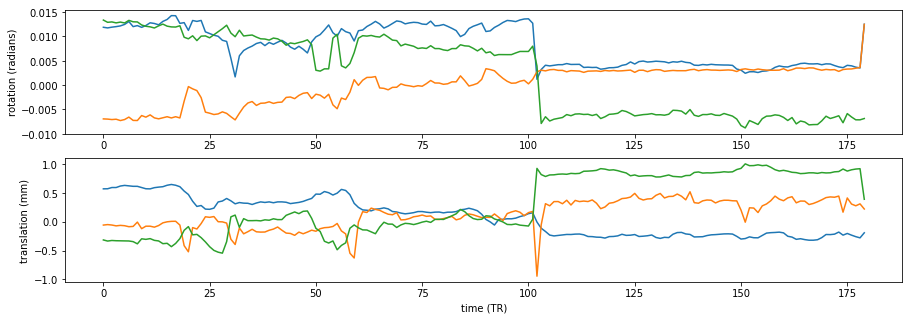

In [19]:
par = np.loadtxt('/data/output/datasink/preproc/sub-01/task-fingerfootlips/sub-01_task-fingerfootlips_bold_roi_mcf.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)')

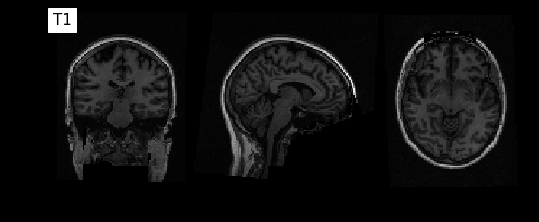

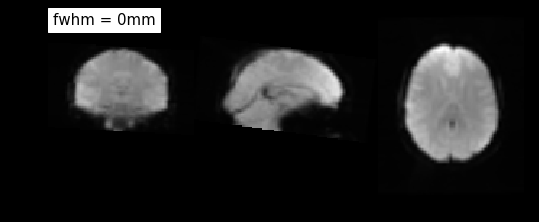

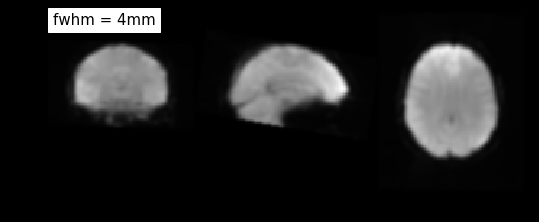

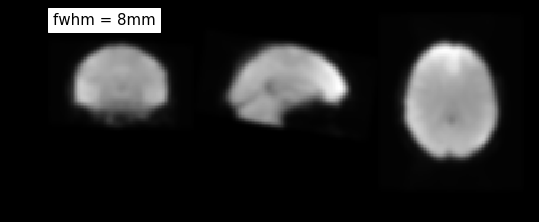

In [20]:
from nilearn import image, plotting
plotting.plot_epi(
    '/data/output/datasink/preproc/sub-02/task-fingerfootlips/sub-02_T1w_resample.nii', title="T1",
    display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

plotting.plot_epi(
    '/data/output/datasink/preproc/sub-02/task-fingerfootlips/sub-02_task-fingerfootlips_bold_roi_mean_flirt.nii.gz', title="fwhm = 0mm",
    display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')


mean_img = image.mean_img('/data/output/datasink/preproc/sub-02/task-fingerfootlips/fwhm-4/ssub-02_task-fingerfootlips_bold_roi_mcf_flirt.nii')
plotting.plot_epi(mean_img, title="fwhm = 4mm", display_mode='ortho',
                  annotate=False, draw_cross=False, cmap='gray')

mean_img = image.mean_img('/data/output/datasink/preproc/sub-02/task-fingerfootlips/fwhm-8/ssub-02_task-fingerfootlips_bold_roi_mcf_flirt.nii')
plotting.plot_epi(mean_img, title="fwhm = 8mm", display_mode='ortho',
                  annotate=False, draw_cross=False, cmap='gray')